In [1]:
import os, sys
import numpy as np
import scipy.io as scpio
import mne
import pandas as pd
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import glob
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
sys.path.append("../../")
from src import preprocessing as prep


In [2]:
subj_id = 14
meg_dir = f'../../datasets/data/subj_{subj_id}/meg/'
plots_dir = f'../../datasets/plots/subj_{subj_id}/'

### RUN ICA


In [3]:
prep.run_ica(meg_dir, write=True, overwrite=False)

TypeError: run_ica() missing 1 required positional argument: 'subjs_dir'

### Reject Components

In [4]:

# Load concatenated MEG data
meg = mne.io.read_raw_fif(os.path.join(meg_dir, 'concat_meg.fif'))

# Load ICA info
ica = mne.preprocessing.read_ica(os.path.join(meg_dir, "matrix_ica.fif"))


Opening raw data file ../../datasets/data/subj_14/meg/concat_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 1573067 =      0.000 ...  5243.557 secs
Ready.
Opening raw data file /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/notebooks/preprocessing/../../datasets/data/subj_14/meg/concat_meg-1.fif...
    Read 5 compensation matrices
    Range : 1573068 ... 1991267 =   5243.560 ...  6637.557 secs
Ready.
Current compensation grade : 3
Reading ../../datasets/data/subj_14/meg/matrix_ica.fif ...
Now restoring ICA solution ...
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Removing 5 compensators from info because not all compensation channels were picked.
Setting 530074 of 1991268 (26.62%) samples to NaN, retaining 1461194 (73.38%) samples.
Effective window size : 6.827 (s)


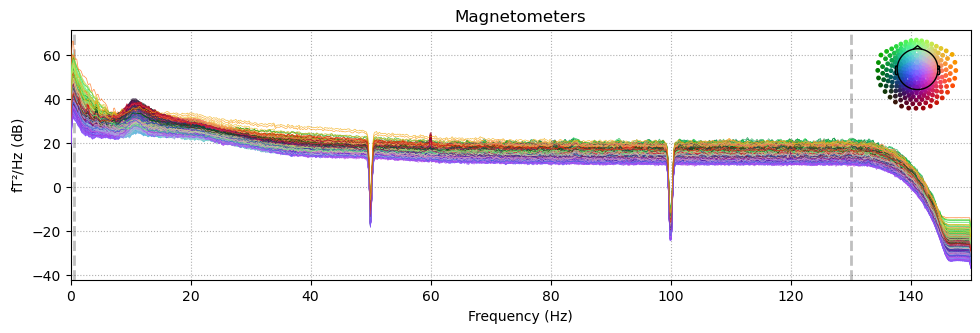

In [5]:
# Plot
%matplotlib qt
meg.plot_psd(fmax=150)
#meg.plot_psd(fmax=40, n_fft=int(meg.info['sfreq']*2), n_overlap=int(meg.info['sfreq']));


In [6]:
ica.plot_components()


[<MNEFigure size 1950x1694 with 20 Axes>,
 <MNEFigure size 1950x1694 with 20 Axes>]

In [7]:

ica.plot_sources(meg.copy(), stop=30, block=True)

Creating RawArray with float64 data, n_channels=40, n_times=1991268
    Range : 0 ... 1991267 =      0.000 ...  6637.557 secs
Ready.
Using qt as 2D backend.
Using pyopengl with version 3.1.6


In [8]:
# Further inspection of selected comps
# #############################################################################
indx_selected_comps_for_inspection = [0, 1, 2, 3, 9, 16, 17, 32, 27, 25, 39, 20, 21, 38, 37]
ica.plot_properties(meg.copy().crop(tmax=60*30), indx_selected_comps_for_inspection)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
529 matching events found
No baseline correction applied
0 pro

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [9]:
indx_rejected_comps = indx_selected_comps_for_inspection
print(f'Rejected comps: {indx_rejected_comps}')

meg_ica = meg.copy()
ica.exclude = indx_rejected_comps
meg_ica.load_data()
ica.apply(meg_ica)  # , n_pca_components=nchans)

Rejected comps: [0, 1, 2, 3, 9, 16, 17, 32, 27, 25, 39, 20, 21, 38, 37]
Reading 0 ... 1991267  =      0.000 ...  6637.557 secs...
Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 15 ICA components
    Projecting back using 275 PCA components


<Raw | concat_meg.fif, 303 x 1991268 (6637.6 s), ~4.50 GB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Removing 5 compensators from info because not all compensation channels were picked.
Setting 530074 of 1991268 (26.62%) samples to NaN, retaining 1461194 (73.38%) samples.
Effective window size : 6.827 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Removing 5 compensators from info because not all compensation channels were picked.
Setting 530074 of 1991268 (26.62%) samples to NaN, retaining 1461194 (73.38%) samples.
Effective window size : 6.827 (s)


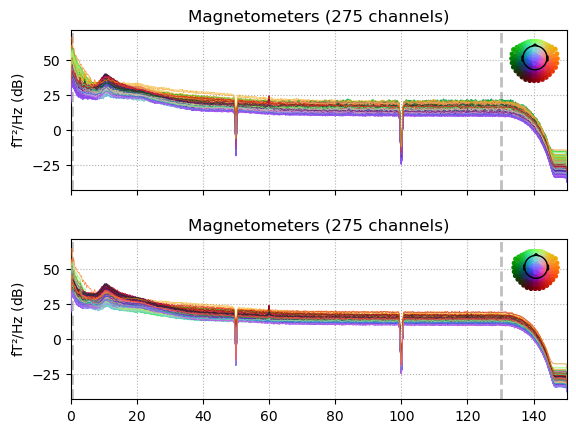

In [10]:
# Plot PSD before and after ICA analysis
# #############################################################################
%matplotlib qt
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
meg.plot_psd(fmax=150, ax=ax[0])
meg_ica.plot_psd(fmax=150, ax=ax[1])



In [11]:
# Save indices of rejected comps to a csv file
np.savetxt(os.path.join(meg_dir, 'indx_rejected_ica_comps.csv'), indx_rejected_comps, delimiter=',')


In [12]:

# Save the data after ICA
write_path = meg_dir
write_name = f"after_ica_subj_{subj_id}_meg.fif"
meg_ica.save(os.path.join(write_path, write_name))

# Save psd Plots
os.makedirs(os.path.join(plots_dir), exist_ok=True)
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
meg.plot_psd(fmax=40, ax=ax[0])
meg_ica.plot_psd(fmax=40, ax=ax[1])
fig.savefig(os.path.join(plots_dir, f'psd_after_ica.jpg'))
plt.close('all')

Writing /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/notebooks/preprocessing/../../datasets/data/subj_14/meg/after_ica_subj_14_meg.fif
Overwriting existing file.
Writing /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/notebooks/preprocessing/../../datasets/data/subj_14/meg/after_ica_subj_14_meg-1.fif
Closing /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/notebooks/preprocessing/../../datasets/data/subj_14/meg/after_ica_subj_14_meg-1.fif
Closing /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/notebooks/preprocessing/../../datasets/data/subj_14/meg/after_ica_subj_14_meg.fif
[done]
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Removing 5 compensators from info because not all compensation channels were picked.
Setting 530074 of 1991268 (26.62%) samples to NaN, retaining 1461194 (73.38%) samples.
Effective window size : 6.827 (s)
NOTE: plot_psd() is a legacy function. New